In [1]:
# Core libraries
import numpy as np, math
import time
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Qiskit core
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate

# IBM Runtime
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler, 
    Session,
    Options
)

# Transpilation
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Classical optimization
from scipy.optimize import minimize

# Custom functions
from QAOA_functions.portfolio_qubo_prep import prepare_portfolio_qubo


# Plotting
import matplotlib.pyplot as plt

from QAOA_functions.portfolio_qubo_prep import prepare_portfolio_qubo

print("✓ All libraries imported successfully")
print(f"  Qiskit version: {__import__('qiskit').__version__}")


✓ All libraries imported successfully
  Qiskit version: 2.2.3


In [2]:
# ===================================================================
# CONFIGURATION PANEL - 3 MODES
# ===================================================================

# MODE SELECTION (choose ONE)
MODE = 'IDEAL'  # Options: 'IDEAL', 'FAKE', 'QPU'

# IBM Quantum credentials (solo para QPU)
IBM_CONFIG = {
    'api_key': "TU_API_KEY_AQUI",
    'instance': "TU_INSTANCE_AQUI",
    'backend_name': None  # None = least_busy
}

# QAOA parameters
QAOA_CONFIG = {
    'p_layers': 10,
    'shots': 4000,
    'max_iter': 120,
    'rhobeg': 2.0,
    'seed': 42
}

# Problem size
PROBLEM_CONFIG = {
    'n_assets': 20,
    'cardinality': 10,
    'start_date': '2020-01-01',
    'end_date': '2025-12-31'

}

# Error Mitigation (FAKE y QPU)
ERROR_MITIGATION = {
    'dynamical_decoupling': True,
    'dd_sequence': 'XY4',
    'measurement_mitigation': True,
    'twirling': False,  # Solo QPU (no funciona en AerSimulator)
    'optimization_level': 3
}

# Advanced
ADVANCED_CONFIG = {
    'final_shots': 8000,
    'resilience_level': 1
}

# MODE VALIDATION
assert MODE in ['IDEAL', 'FAKE', 'QPU'], "MODE must be 'IDEAL', 'FAKE', or 'QPU'"

print("="*60)
print("  QAOA WITH ERROR MITIGATION - 3 MODES")
print("="*60)
print(f"\n🔧 Mode: {MODE}")
print(f"📊 Problem: N={PROBLEM_CONFIG['n_assets']}, B={PROBLEM_CONFIG['cardinality']}")

if MODE == 'IDEAL':
    print("⚡ Ideal simulation (no noise, no error mitigation)")
elif MODE == 'FAKE':
    print("🎭 Fake backend simulation (realistic noise model)")
    print(f"🛡️  Error Mitigation:")
    print(f"   - Dynamical Decoupling: {ERROR_MITIGATION['dynamical_decoupling']}")
    print(f"   - Measurement Mitigation: {ERROR_MITIGATION['measurement_mitigation']}")
else:  # QPU
    print("🚀 Real QPU execution")
    print(f"🛡️  Error Mitigation:")
    for k, v in ERROR_MITIGATION.items():
        if k != 'optimization_level':
            print(f"   - {k}: {v}")

print("="*60)


  QAOA WITH ERROR MITIGATION - 3 MODES

🔧 Mode: IDEAL
📊 Problem: N=20, B=10
⚡ Ideal simulation (no noise, no error mitigation)


In [3]:
print("\n🔗 Connecting to backend...")

if MODE == 'IDEAL':
    # ===== IDEAL: Sin ruido =====
    from qiskit_aer import AerSimulator
    backend = AerSimulator()
    
    print(f"✓ Using IDEAL simulator (AerSimulator)")
    print(f"  Noise model: None")
    print(f"  Error rates: 0%")
    print(f"  ⚡ Fastest mode (no error mitigation needed)")

elif MODE == 'FAKE':
    # ===== FAKE: Con noise model realista =====
    from qiskit_aer import AerSimulator
    from qiskit_ibm_runtime.fake_provider import FakeMarrakesh
    from qiskit_aer.noise import NoiseModel
    
    fake_backend = FakeMarrakesh()
    noise_model = NoiseModel.from_backend(fake_backend)  # ← CLAVE: Extraer noise
    
    backend = AerSimulator(noise_model=noise_model)  # ← Simulador CON ruido
    
    print(f"✓ Using FAKE backend with noise: {fake_backend.name}")
    print(f"  Noise model: Loaded from {fake_backend.name}")
    print(f"  Error rates: ~1-2% (realistic)")
    print(f"  Qubits available: {backend.num_qubits}")
    print(f"  🎭 Realistic simulation with error mitigation")

else:  # MODE == 'QPU'
    # ===== QPU: Hardware real =====
    from qiskit_ibm_runtime import QiskitRuntimeService
    
    service = QiskitRuntimeService(
        channel="ibm_cloud",
        token=IBM_CONFIG['api_key'],
        instance=IBM_CONFIG['instance']
    )
    
    if IBM_CONFIG['backend_name']:
        backend = service.backend(IBM_CONFIG['backend_name'])
    else:
        backend = service.least_busy(
            simulator=False, 
            operational=True, 
            min_num_qubits=PROBLEM_CONFIG['n_assets']
        )
    
    print(f"✓ Connected to REAL backend: {backend.name}")
    print(f"  Qubits: {backend.num_qubits}")
    print(f"  Queue: {backend.status().pending_jobs} jobs")
    print(f"  🚀 Real quantum hardware with full error mitigation")

print()


🔗 Connecting to backend...
✓ Using IDEAL simulator (AerSimulator)
  Noise model: None
  Error rates: 0%
  ⚡ Fastest mode (no error mitigation needed)



In [4]:
print(f"\n📊 Generating portfolio problem (NO PENALTY - XY mixer handles it)...")

n = PROBLEM_CONFIG['n_assets']
B = PROBLEM_CONFIG['cardinality']
START_DATE = PROBLEM_CONFIG['start_date']
END_DATE = PROBLEM_CONFIG['end_date']

"""
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 
           'META', 'TSLA', 'JPM', 'JNJ', 'V'][:n]
"""


TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA',
           'META', 'TSLA', 'JPM', 'JNJ', 'V',
           'WMT', 'PG', 'UNH', 'HD', 'MA',
           'DIS', 'NFLX', 'PYPL', 'ADP', 'ADBE'][:n]


# VERY differentiated returns and risks
np.random.seed(42)

# QUBO: SOLO risk-return tradeoff (NO PENALTY!)
risk_aversion = 0.5  # Balance risk vs return

# Prepare QUBO data
print("Preparing portfolio QUBO data...")
data = prepare_portfolio_qubo(
    tickers=TICKERS,
    start_date=START_DATE,
    end_date=END_DATE,
    B=B,
    lambda_param=risk_aversion
)

mu = data['mu']
volatilities = data['returns'].std().values
Sigma = data['Sigma']
Q = data['Q']
q = data['q']

# QUBO to Ising
def qubo_to_ising(Q, q):
    n = len(q)
    J = np.zeros((n, n))
    h = np.zeros(n)
    const = 0.0
    
    for i in range(n):
        for j in range(i+1, n):
            Jij = Q[i, j] / 4.0
            J[i, j] = Jij
            h[i] += -Q[i, j] / 4.0
            h[j] += -Q[i, j] / 4.0
            const += Q[i, j] / 4.0
    
    for i in range(n):
        h[i] += -(Q[i, i] / 2.0) - (q[i] / 2.0)
        const += (Q[i, i] / 2.0) + (q[i] / 2.0)
    
    return J, h, const

J, h, const_shift = qubo_to_ising(Q, q)

print(f"\n✓ Problem generated:")
print(f"  Assets: {n}, Cardinality: {B}")
print(f"  Valid states: {math.comb(n, B)}")
print(f"  Risk aversion: {risk_aversion}")
print(f"  h range: [{h.min():.4f}, {h.max():.4f}]")
print(f"  J nonzero: {np.count_nonzero(J)}")

# Test portfolios with VERY different characteristics
test_portfolios = [
    ('High Return/High Risk', [4, 0, 1, 8]),   # NVDA, AAPL, MSFT, JNJ
    ('Balanced', [0, 1, 2, 3]),                 # AAPL, MSFT, GOOGL, AMZN
    ('Low Risk/Low Return', [5, 6, 7, 9])      # META, TSLA, JPM, V
]

print(f"\n  Test portfolios (SHOULD BE VERY DIFFERENT):")
for name, portfolio in test_portfolios:
    x_test = np.zeros(n, dtype=int)
    x_test[portfolio] = 1
    
    cost_test = x_test @ Q @ x_test + q @ x_test
    ret_test = 252 * mu[portfolio].mean()
    risk_test = np.sqrt(252* x_test @ Sigma @ x_test ) / B
    sharpe_test = ret_test / risk_test if risk_test > 1e-6 else 0
    
    tickers_test = [TICKERS[i] for i in portfolio]
    print(f"    {name}:")
    print(f"      Tickers: {tickers_test}")
    print(f"      QUBO cost: {cost_test:.4f}  (Return: {ret_test*100:.1f}%, Risk: {risk_test*100:.1f}%, Sharpe: {sharpe_test:.3f})")




📊 Generating portfolio problem (NO PENALTY - XY mixer handles it)...
Preparing portfolio QUBO data...

✓ Problem generated:
  Assets: 20, Cardinality: 10
  Valid states: 184756
  Risk aversion: 0.5
  h range: [-0.1148, -0.0202]
  J nonzero: 190

  Test portfolios (SHOULD BE VERY DIFFERENT):
    High Return/High Risk:
      Tickers: ['NVDA', 'AAPL', 'MSFT', 'JNJ']
      QUBO cost: 0.2114  (Return: 9.0%, Risk: 10.3%, Sharpe: 0.868)
    Balanced:
      Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
      QUBO cost: 0.2229  (Return: 11.8%, Risk: 10.6%, Sharpe: 1.114)
    Low Risk/Low Return:
      Tickers: ['META', 'TSLA', 'JPM', 'V']
      QUBO cost: 0.1394  (Return: 13.9%, Risk: 8.4%, Sharpe: 1.659)


In [5]:
print(f"\n✓ Smart warm-start initialization:")

# Top B assets by Sharpe ratio
sharpe_individual = (252 * mu) / (np.sqrt(252 * np.diag(Sigma)) + 1e-10)
sharpe_sorted = np.argsort(-sharpe_individual)

init_bits = np.zeros(n, dtype=int)
init_bits[sharpe_sorted[:B]] = 1

print(f"  Portfolio: {[TICKERS[i] for i in sharpe_sorted[:B]]}")
print(f"  Initial cost: {init_bits @ Q @ init_bits + q @ init_bits:.2f}")
print(f"  Avg Sharpe: {sharpe_individual[sharpe_sorted[:B]].mean():.3f}")



✓ Smart warm-start initialization:
  Portfolio: ['HD', 'ADBE', 'META', 'NFLX', 'AAPL', 'PG', 'JNJ', 'WMT', 'JPM', 'AMZN']
  Initial cost: 1.32
  Avg Sharpe: 0.657


In [6]:
def f_qubo(x: np.ndarray) -> float:
    return float(x @ Q @ x + q @ x)

def bitarray_from_qiskit_string(s: str) -> np.ndarray:
    return np.array([int(c) for c in s[::-1]], dtype=int)

def is_valid(x: np.ndarray, B: int) -> bool:
    return np.sum(x) == B

def random_theta(size: int, rng: np.random.Generator) -> np.ndarray:
    return rng.uniform(0, 2*np.pi, size=size)


In [7]:
def build_qaoa_xy(n: int, P: int, J: np.ndarray, h: np.ndarray, 
                  init_bits: np.ndarray) -> Tuple[QuantumCircuit, List[Parameter]]:
    qc = QuantumCircuit(n, name="QAOA_XY")
    
    for i, bit in enumerate(init_bits):
        if bit == 1:
            qc.x(i)
    
    gammas = [Parameter(f"γ{k}") for k in range(P)]
    betas = [Parameter(f"β{k}") for k in range(P)]
    
    ring_pairs = [(i, (i+1) % n) for i in range(n)]
    
    for layer in range(P):
        γ = gammas[layer]
        β = betas[layer]
        
        for i in range(n):
            if abs(h[i]) > 1e-15:
                qc.rz(2.0 * γ * h[i], i)
        
        for i in range(n):
            for j in range(i+1, n):
                if abs(J[i, j]) > 1e-15:
                    qc.append(RZZGate(2.0 * γ * J[i, j]), [i, j])
        
        for (i, j) in ring_pairs:
            qc.append(RXXGate(2.0 * β), [i, j])
            qc.append(RYYGate(2.0 * β), [i, j])
    
    qc.measure_all()
    
    return qc, gammas + betas

P_LAYERS = QAOA_CONFIG['p_layers']
ansatz, theta_params = build_qaoa_xy(n, P_LAYERS, J, h, init_bits)

print(f"\n✓ QAOA circuit:")
print(f"  Layers: {P_LAYERS}")
print(f"  Depth: {ansatz.depth()}")
print(f"  Parameters: {len(theta_params)}")



✓ QAOA circuit:
  Layers: 10
  Depth: 612
  Parameters: 20


In [8]:
print("\n⚙️  Transpiling with error mitigation...")

if MODE == 'IDEAL':
    # ===== IDEAL: Transpilación simple sin DD =====
    from qiskit import transpile
    
    transpiled_ansatz = transpile(
        ansatz,
        backend=backend,
        optimization_level=ERROR_MITIGATION['optimization_level'],
        seed_transpiler=QAOA_CONFIG['seed']
    )
    
    print("✓ Transpilation complete (no noise, no error mitigation)")

elif MODE == 'FAKE':
    # ===== FAKE: Transpilación con noise model (SIN DD) =====
    from qiskit import transpile
    
    transpiled_ansatz = transpile(
        ansatz,
        backend=backend,
        optimization_level=ERROR_MITIGATION['optimization_level'],
        seed_transpiler=QAOA_CONFIG['seed']
    )
    
    print("✓ Transpilation complete with noise model")
    print("  Note: Noise model active (gate errors, readout errors)")
    print("  DD not applied in simulation mode (not needed)")

else:  # MODE == 'QPU'
    # ===== QPU: Transpilación completa con DD =====
    pm = generate_preset_pass_manager(
        optimization_level=ERROR_MITIGATION['optimization_level'],
        target=backend.target
    )
    
    transpiled_ansatz = pm.run(ansatz)
    
    # Add Dynamical Decoupling
    if ERROR_MITIGATION['dynamical_decoupling']:
        from qiskit.transpiler import PassManager
        from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
        from qiskit.circuit.library import XGate, YGate
        
        dd_sequence = [XGate(), YGate(), XGate(), YGate()]
        
        dd_pm = PassManager([
            ALAPScheduleAnalysis(backend.target),
            PadDynamicalDecoupling(backend.target, dd_sequence)
        ])
        
        transpiled_ansatz = dd_pm.run(transpiled_ansatz)
        print("  ✅ Dynamical Decoupling (XY4) applied")
    
    print(f"✓ Transpilation complete with full error mitigation")

print(f"  Transpiled depth: {transpiled_ansatz.depth()}")
print(f"  Parameters preserved: {len(transpiled_ansatz.parameters)}")



⚙️  Transpiling with error mitigation...
✓ Transpilation complete (no noise, no error mitigation)
  Transpiled depth: 612
  Parameters preserved: 20


In [9]:
print("\n" + "="*60)
print("  QAOA OPTIMIZATION")
print("="*60)

rng = np.random.default_rng(QAOA_CONFIG['seed'])
t_start = time.time()
iteration = [0]
cost_history = []

if MODE in ['IDEAL', 'FAKE']:
    # ===== IDEAL y FAKE usan AerSampler =====
    from qiskit_aer.primitives import Sampler as AerSampler
    sampler = AerSampler()
    
    def objective_func(theta: np.ndarray) -> float:
        """Objective function for IDEAL/FAKE modes."""
        param_values = {theta_params[i]: theta[i] for i in range(len(theta_params))}
        
        bound_circuit = transpiled_ansatz.assign_parameters(param_values)
        job = sampler.run([bound_circuit], shots=QAOA_CONFIG['shots'])
        result = job.result()
        pub_result = result.quasi_dists[0]
        
        total_cost, valid = 0.0, 0
        for bitstring_int, prob in pub_result.items():
            bitstring = format(bitstring_int, f'0{n}b')
            x = bitarray_from_qiskit_string(bitstring)
            count = int(prob * QAOA_CONFIG['shots'])
            
            if is_valid(x, B):
                total_cost += count * f_qubo(x)
                valid += count
        
        if valid == 0:
            return 1e9
        
        avg_cost = total_cost / valid
        cost_history.append(avg_cost)
        iteration[0] += 1
        
        if iteration[0] % 10 == 0:
            print(f"  Iter {iteration[0]:2d}: {avg_cost:.3f}")
        
        return avg_cost

else:  # MODE == 'QPU'
    # ===== QPU REAL con error mitigation completo =====
    options = Options()
    options.execution.shots = QAOA_CONFIG['shots']
    options.optimization_level = ERROR_MITIGATION['optimization_level']
    options.resilience_level = ADVANCED_CONFIG['resilience_level']
    
    # Enable measurement error mitigation
    if ERROR_MITIGATION['measurement_mitigation']:
        options.resilience.measure_mitigation = True
        print("  ✅ Measurement mitigation enabled")
    
    # Enable twirling (solo QPU)
    if ERROR_MITIGATION['twirling']:
        options.twirling.enable_gates = True
        options.twirling.enable_measure = True
        print("  ✅ Twirling enabled")
    
    session = Session(backend=backend)
    sampler = Sampler(session=session, options=options)
    
    def objective_func(theta: np.ndarray) -> float:
        """Objective function for QPU mode."""
        param_values = {theta_params[i]: theta[i] for i in range(len(theta_params))}
        
        bound_circuit = transpiled_ansatz.assign_parameters(param_values)
        job = sampler.run([bound_circuit])
        result = job.result()
        counts = result[0].data.meas.get_counts()
        
        total_cost, valid = 0.0, 0
        for bitstring, count in counts.items():
            x = bitarray_from_qiskit_string(bitstring)
            if is_valid(x, B):
                total_cost += count * f_qubo(x)
                valid += count
        
        if valid == 0:
            return 1e9
        
        avg_cost = total_cost / valid
        cost_history.append(avg_cost)
        iteration[0] += 1
        
        if iteration[0] % 10 == 0:
            print(f"  Iter {iteration[0]:2d}: {avg_cost:.3f}")
        
        return avg_cost

# ===== OPTIMIZATION (común para los 3 modos) =====
x0 = random_theta(2*P_LAYERS, rng)

print(f"\nStarting COBYLA optimization...")
print(f"  Initial parameters: {len(x0)} values")
print(f"  Max iterations: {QAOA_CONFIG['max_iter']}")

result = minimize(
    objective_func, x0, method='COBYLA',
    options={'maxiter': QAOA_CONFIG['max_iter'], 'rhobeg': QAOA_CONFIG['rhobeg']}
)

best_theta = result.x
best_cost = result.fun

# Cleanup para QPU
if MODE == 'QPU':
    session.close()
    print("  ✓ QPU session closed")

t_opt = time.time() - t_start

print(f"\n✓ Optimization complete in {t_opt:.1f}s")
print(f"  Best cost: {best_cost:.3f}")
print(f"  Iterations: {len(cost_history)}")
print(f"  Mode: {MODE}")



  QAOA OPTIMIZATION

Starting COBYLA optimization...
  Initial parameters: 20 values
  Max iterations: 120
  Iter 10: 1.139
  Iter 20: 1.078
  Iter 30: 0.999
  Iter 40: 1.021
  Iter 50: 1.092
  Iter 60: 0.990
  Iter 70: 1.004
  Iter 80: 0.971
  Iter 90: 0.963
  Iter 100: 0.972
  Iter 110: 0.973
  Iter 120: 0.972

✓ Optimization complete in 103.3s
  Best cost: 0.963
  Iterations: 120
  Mode: IDEAL


In [10]:
print("\n📊 Final sampling...")

if MODE in ['IDEAL', 'FAKE']:  # ← ÚNICA LÍNEA QUE CAMBIA
    from qiskit_aer.primitives import Sampler as AerSampler
    sampler = AerSampler()
    param_values = {theta_params[i]: best_theta[i] for i in range(len(theta_params))}
    final_circuit = transpiled_ansatz.assign_parameters(param_values)
    job = sampler.run([final_circuit], shots=ADVANCED_CONFIG['final_shots'])
    result = job.result()
    pub_result = result.quasi_dists[0]
    counts = {}
    for bitstring_int, prob in pub_result.items():
        bitstring = format(bitstring_int, f'0{n}b')
        counts[bitstring] = int(prob * ADVANCED_CONFIG['final_shots'])
else:
    options = Options()
    options.execution.shots = ADVANCED_CONFIG['final_shots']
    options.resilience_level = ADVANCED_CONFIG['resilience_level']
    if ERROR_MITIGATION['measurement_mitigation']:
        options.resilience.measure_mitigation = True
    if ERROR_MITIGATION['twirling']:
        options.twirling.enable_gates = True
        options.twirling.enable_measure = True
    
    param_values = {theta_params[i]: best_theta[i] for i in range(len(theta_params))}
    final_circuit = transpiled_ansatz.assign_parameters(param_values)
    session = Session(backend=backend)
    sampler = Sampler(session=session, options=options)
    job = sampler.run([final_circuit])
    result = job.result()
    counts = result[0].data.meas.get_counts()
    session.close()

valid_solutions = []
for bitstring, count in counts.items():
    x = bitarray_from_qiskit_string(bitstring)
    if is_valid(x, B):
        cost = f_qubo(x)
        valid_solutions.append((bitstring, count, cost, x))

valid_solutions.sort(key=lambda t: t[2])

if valid_solutions:
    s_best, c_best, fx_best, x_best = valid_solutions[0]
    sel_idx = np.where(x_best == 1)[0]
    sel_tickers = [TICKERS[i] for i in sel_idx]
    
    # CORRECCIÓN: Calcular métricas correctamente
    w = np.zeros(n)
    w[sel_idx] = 1.0 / B
    
    # mu y volatilities ya están en términos anualizados
    mu_portfolio = float(mu[sel_idx].mean())  # Promedio de retornos
    vol_portfolio = float(volatilities[sel_idx].mean())  # Promedio de volatilidades
    sharpe = mu_portfolio / vol_portfolio if vol_portfolio > 1e-6 else 0.0
    
    print(f"\n{'='*60}")
    print("  QAOA RESULTS")
    print(f"{'='*60}")
    print(f"Portfolio: {', '.join(sel_tickers)}")
    print(f"\n📈 Performance:")
    print(f"  QUBO cost: {fx_best:.4f}")
    print(f"  Avg Return: {mu_portfolio*100:.2f}%")
    print(f"  Avg Volatility: {vol_portfolio*100:.2f}%")
    print(f"  Sharpe Ratio: {sharpe:.3f}")
    print(f"\n📊 Measurement Stats:")
    print(f"  Best solution freq: {c_best}/{ADVANCED_CONFIG['final_shots']} ({c_best/ADVANCED_CONFIG['final_shots']*100:.2f}%)")
    valid_total = sum(s[1] for s in valid_solutions)
    print(f"  Valid solutions: {valid_total}/{ADVANCED_CONFIG['final_shots']} ({valid_total/ADVANCED_CONFIG['final_shots']*100:.1f}%)")
    print(f"  Unique costs: {len(set([s[2] for s in valid_solutions]))}")
    
    # Top 5 solutions
    print(f"\n🏆 Top 5 Solutions:")
    for i, (bs, cnt, cst, x_sol) in enumerate(valid_solutions[:5]):
        idx_sol = np.where(x_sol == 1)[0]
        tick_sol = [TICKERS[j] for j in idx_sol]
        freq_pct = cnt / ADVANCED_CONFIG['final_shots'] * 100
        print(f"  {i+1}. {tick_sol}")
        print(f"     Cost: {cst:.4f}, Freq: {cnt} ({freq_pct:.2f}%)")
else:
    print("❌ No valid solutions")




📊 Final sampling...

  QAOA RESULTS
Portfolio: GOOGL, META, TSLA, JPM, JNJ, UNH, MA, PYPL, ADP, ADBE

📈 Performance:
  QUBO cost: 0.7057
  Avg Return: 0.05%
  Avg Volatility: 1.82%
  Sharpe Ratio: 0.028

📊 Measurement Stats:
  Best solution freq: 2/8000 (0.03%)
  Valid solutions: 8000/8000 (100.0%)
  Unique costs: 4720

🏆 Top 5 Solutions:
  1. ['GOOGL', 'META', 'TSLA', 'JPM', 'JNJ', 'UNH', 'MA', 'PYPL', 'ADP', 'ADBE']
     Cost: 0.7057, Freq: 2 (0.03%)
  2. ['GOOGL', 'AMZN', 'TSLA', 'JPM', 'JNJ', 'UNH', 'MA', 'PYPL', 'ADP', 'ADBE']
     Cost: 0.7060, Freq: 2 (0.03%)
  3. ['GOOGL', 'AMZN', 'TSLA', 'JPM', 'JNJ', 'PG', 'MA', 'PYPL', 'ADP', 'ADBE']
     Cost: 0.7071, Freq: 1 (0.01%)
  4. ['GOOGL', 'AMZN', 'NVDA', 'TSLA', 'JPM', 'JNJ', 'MA', 'PYPL', 'ADP', 'ADBE']
     Cost: 0.7075, Freq: 1 (0.01%)
  5. ['GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'JPM', 'JNJ', 'MA', 'PYPL', 'ADBE']
     Cost: 0.7100, Freq: 3 (0.04%)


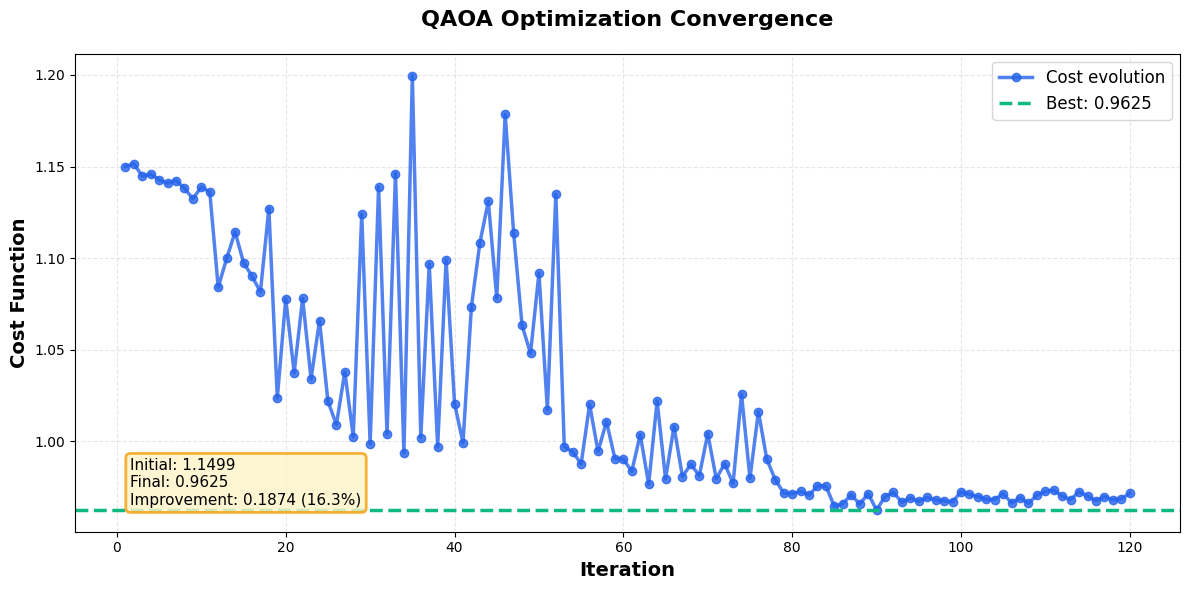

✓ Convergence: 120 iterations, improvement: 0.1874


In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot convergencia
iterations = range(1, len(cost_history)+1)
ax.plot(iterations, cost_history, 
        marker='o', markersize=6, linewidth=2.5, alpha=0.8, 
        color='#2563eb', label='Cost evolution')

# Línea del mejor valor
ax.axhline(y=best_cost, color='#10b981', linestyle='--', 
           linewidth=2.5, label=f'Best: {best_cost:.4f}')

# Calcular mejora
if len(cost_history) > 0:
    improvement = abs(cost_history[0] - best_cost)
    improvement_pct = (improvement / abs(cost_history[0])) * 100
    ax.text(0.05, 0.05, 
            f'Initial: {cost_history[0]:.4f}\nFinal: {best_cost:.4f}\nImprovement: {improvement:.4f} ({improvement_pct:.1f}%)', 
            transform=ax.transAxes, fontsize=11, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='#fef3c7', alpha=0.8, edgecolor='#f59e0b', linewidth=2))

ax.set_xlabel('Iteration', fontsize=14, fontweight='bold')
ax.set_ylabel('Cost Function', fontsize=14, fontweight='bold')
ax.set_title('QAOA Optimization Convergence', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=12, loc='upper right')
plt.tight_layout()
fig.savefig("qaoa_convergence.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✓ Convergence: {len(cost_history)} iterations, improvement: {improvement:.4f}")


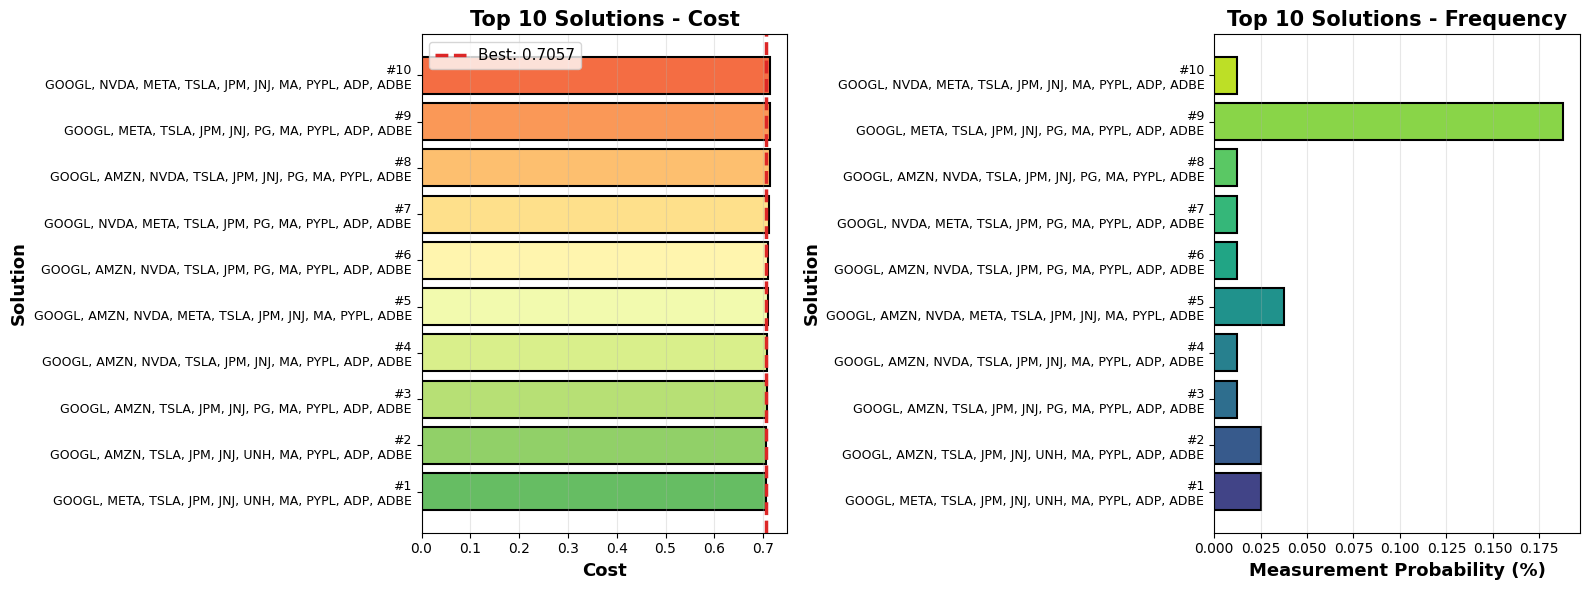

✓ Top solution dominance: 0.03% of measurements


In [12]:
top_10 = valid_solutions[:min(10, len(valid_solutions))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Costs
labels = []
costs = []
for i, (bs, cnt, cst, x_sol) in enumerate(top_10):
    idx_sol = np.where(x_sol == 1)[0]
    tick_sol = [TICKERS[j] for j in idx_sol]
    labels.append(f"#{i+1}\n{', '.join(tick_sol)}")
    costs.append(cst)

y_pos = np.arange(len(labels))
colors_cost = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_10)))

bars1 = ax1.barh(y_pos, costs, color=colors_cost, edgecolor='black', linewidth=1.5)
ax1.axvline(x=fx_best, color='#dc2626', linestyle='--', linewidth=2.5, label=f'Best: {fx_best:.4f}')
ax1.set_xlabel('Cost', fontsize=13, fontweight='bold')
ax1.set_ylabel('Solution', fontsize=13, fontweight='bold')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(labels, fontsize=9)
ax1.set_title('Top 10 Solutions - Cost', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='x')

# Subplot 2: Frequencies
freqs = [s[1]/ADVANCED_CONFIG['final_shots']*100 for s in top_10]
colors_freq = plt.cm.viridis(np.linspace(0.2, 0.9, len(top_10)))

bars2 = ax2.barh(y_pos, freqs, color=colors_freq, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Measurement Probability (%)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Solution', fontsize=13, fontweight='bold')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels, fontsize=9)
ax2.set_title('Top 10 Solutions - Frequency', fontsize=15, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars2, freqs)):
    if val > 5:  # Solo mostrar si >5%
        ax2.text(val/2, bar.get_y() + bar.get_height()/2, 
                f'{val:.1f}%', ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

print(f"✓ Top solution dominance: {freqs[0]:.2f}% of measurements")


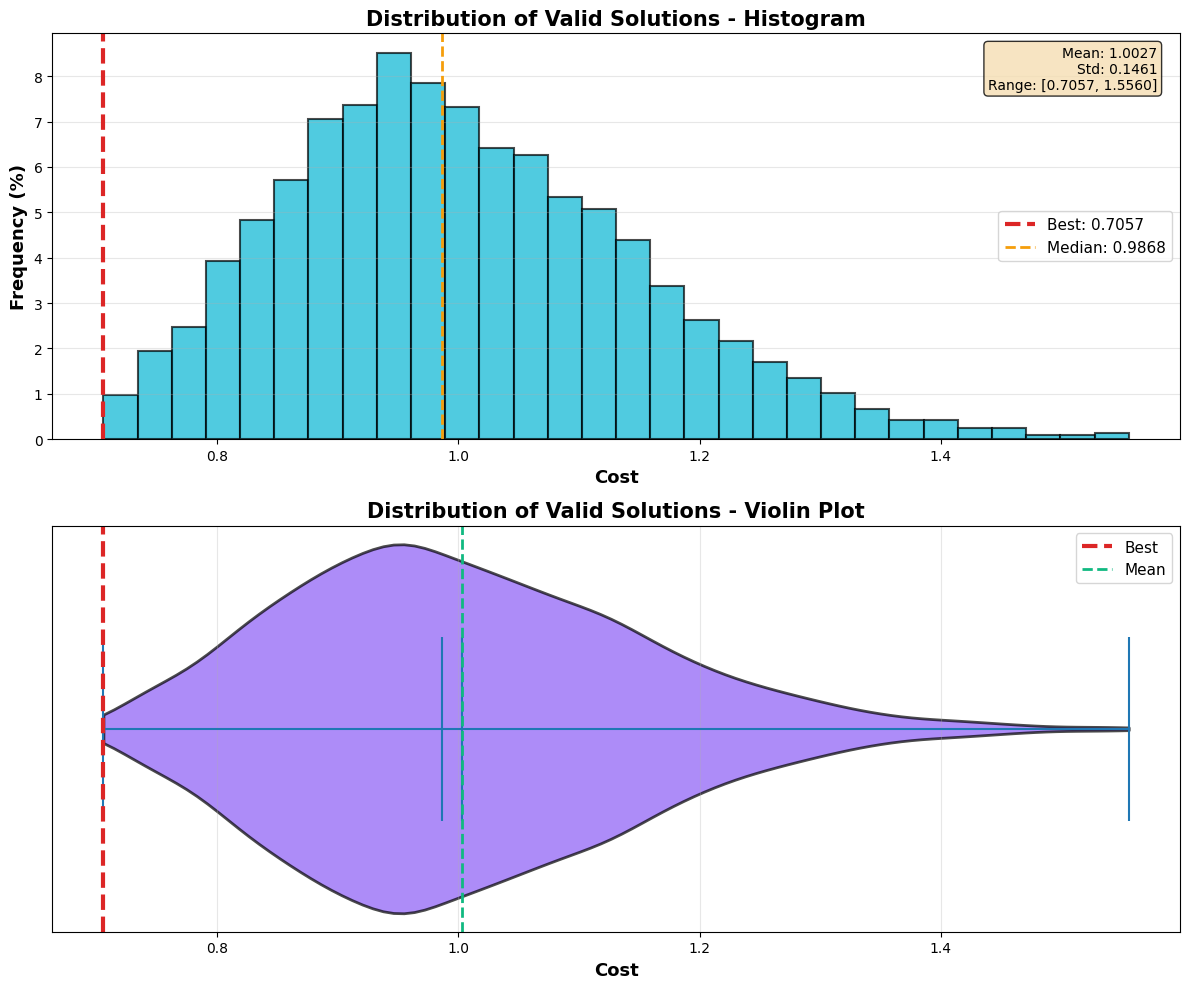

✓ Cost distribution: 4720 unique values


In [13]:
costs_all = [s[2] for s in valid_solutions]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Histograma
n_bins = min(30, len(set(costs_all)))
ax1.hist(costs_all, bins=n_bins, color='#06b6d4', edgecolor='black', 
         alpha=0.7, linewidth=1.5, weights=np.ones(len(costs_all))/len(costs_all)*100)
ax1.axvline(x=fx_best, color='#dc2626', linestyle='--', 
            linewidth=3, label=f'Best: {fx_best:.4f}')
ax1.axvline(x=np.median(costs_all), color='#f59e0b', linestyle='--', 
            linewidth=2, label=f'Median: {np.median(costs_all):.4f}')
ax1.set_xlabel('Cost', fontsize=13, fontweight='bold')
ax1.set_ylabel('Frequency (%)', fontsize=13, fontweight='bold')
ax1.set_title('Distribution of Valid Solutions - Histogram', 
              fontsize=15, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Añadir estadísticas
stats_text = f'Mean: {np.mean(costs_all):.4f}\nStd: {np.std(costs_all):.4f}\nRange: [{min(costs_all):.4f}, {max(costs_all):.4f}]'
ax1.text(0.98, 0.97, stats_text, transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Violin plot
parts = ax2.violinplot([costs_all], vert=False, widths=0.7,
                       showmeans=True, showmedians=True, showextrema=True)
for pc in parts['bodies']:
    pc.set_facecolor('#8b5cf6')
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(2)

ax2.axvline(x=fx_best, color='#dc2626', linestyle='--', linewidth=3, label='Best')
ax2.axvline(x=np.mean(costs_all), color='#10b981', linestyle='--', linewidth=2, label='Mean')
ax2.set_xlabel('Cost', fontsize=13, fontweight='bold')
ax2.set_title('Distribution of Valid Solutions - Violin Plot', 
              fontsize=15, fontweight='bold')
ax2.set_yticks([])
ax2.legend(fontsize=11, loc='upper right')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"✓ Cost distribution: {len(set(costs_all))} unique values")


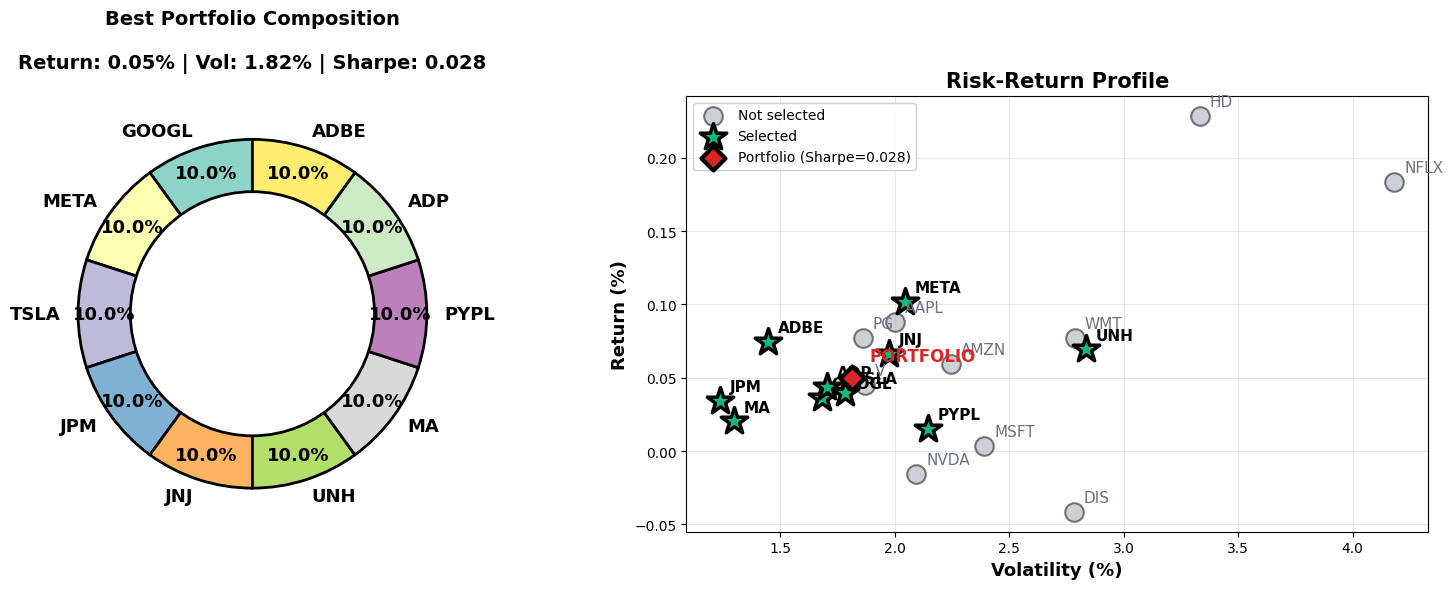

✓ Portfolio: 10 assets selected


In [14]:
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])

# Subplot 1: Portfolio Pie Chart
ax1 = fig.add_subplot(gs[0])
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(sel_tickers)))
wedges, texts, autotexts = ax1.pie(
    [1/B]*B, labels=sel_tickers, autopct='%1.1f%%', 
    startangle=90, colors=colors_pie,
    textprops={'fontsize': 13, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 2},
    pctdistance=0.85
)

# Añadir círculo blanco en el centro (donut chart)
centre_circle = plt.Circle((0,0), 0.70, fc='white', linewidth=2, edgecolor='black')
ax1.add_artist(centre_circle)

ax1.set_title(f'Best Portfolio Composition\n\nReturn: {mu_portfolio*100:.2f}% | Vol: {vol_portfolio*100:.2f}% | Sharpe: {sharpe:.3f}', 
              fontsize=14, fontweight='bold', pad=20)

# Subplot 2: Risk-Return Scatter
ax2 = fig.add_subplot(gs[1])

# Calcular para todos los activos
returns_all = mu * 100
risks_all = volatilities * 100

# Mask para seleccionados
selected_mask = np.zeros(n, dtype=bool)
selected_mask[sel_idx] = True

# Plot no seleccionados
ax2.scatter(risks_all[~selected_mask], returns_all[~selected_mask], 
            s=180, alpha=0.5, color='#9ca3af', label='Not selected', 
            edgecolors='black', linewidth=1.5, zorder=2)

# Plot seleccionados
ax2.scatter(risks_all[selected_mask], returns_all[selected_mask], 
            s=400, alpha=1.0, color='#10b981', label='Selected', 
            edgecolors='black', linewidth=2.5, marker='*', zorder=3)

# Etiquetas para todos
for i in range(n):
    color = 'black' if selected_mask[i] else '#6b7280'
    weight = 'bold' if selected_mask[i] else 'normal'
    ax2.annotate(TICKERS[i], (risks_all[i], returns_all[i]), 
                fontsize=11, fontweight=weight, color=color,
                xytext=(7, 7), textcoords='offset points', zorder=4)

# Portfolio point
ax2.scatter([vol_portfolio*100], [mu_portfolio*100], s=150, alpha=1.0, 
            color='#dc2626', label=f'Portfolio (Sharpe={sharpe:.3f})', 
            edgecolors='black', linewidth=3, marker='D', zorder=5)
ax2.annotate('PORTFOLIO', (vol_portfolio*100, mu_portfolio*100), 
            fontsize=12, fontweight='bold', color='#dc2626',
            xytext=(12, 12), textcoords='offset points', zorder=6)

ax2.set_xlabel('Volatility (%)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Return (%)', fontsize=13, fontweight='bold')
ax2.set_title('Risk-Return Profile', fontsize=15, fontweight='bold')
ax2.legend(fontsize=10, loc='best', framealpha=0.9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('risk-return.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✓ Portfolio: {len(sel_tickers)} assets selected")


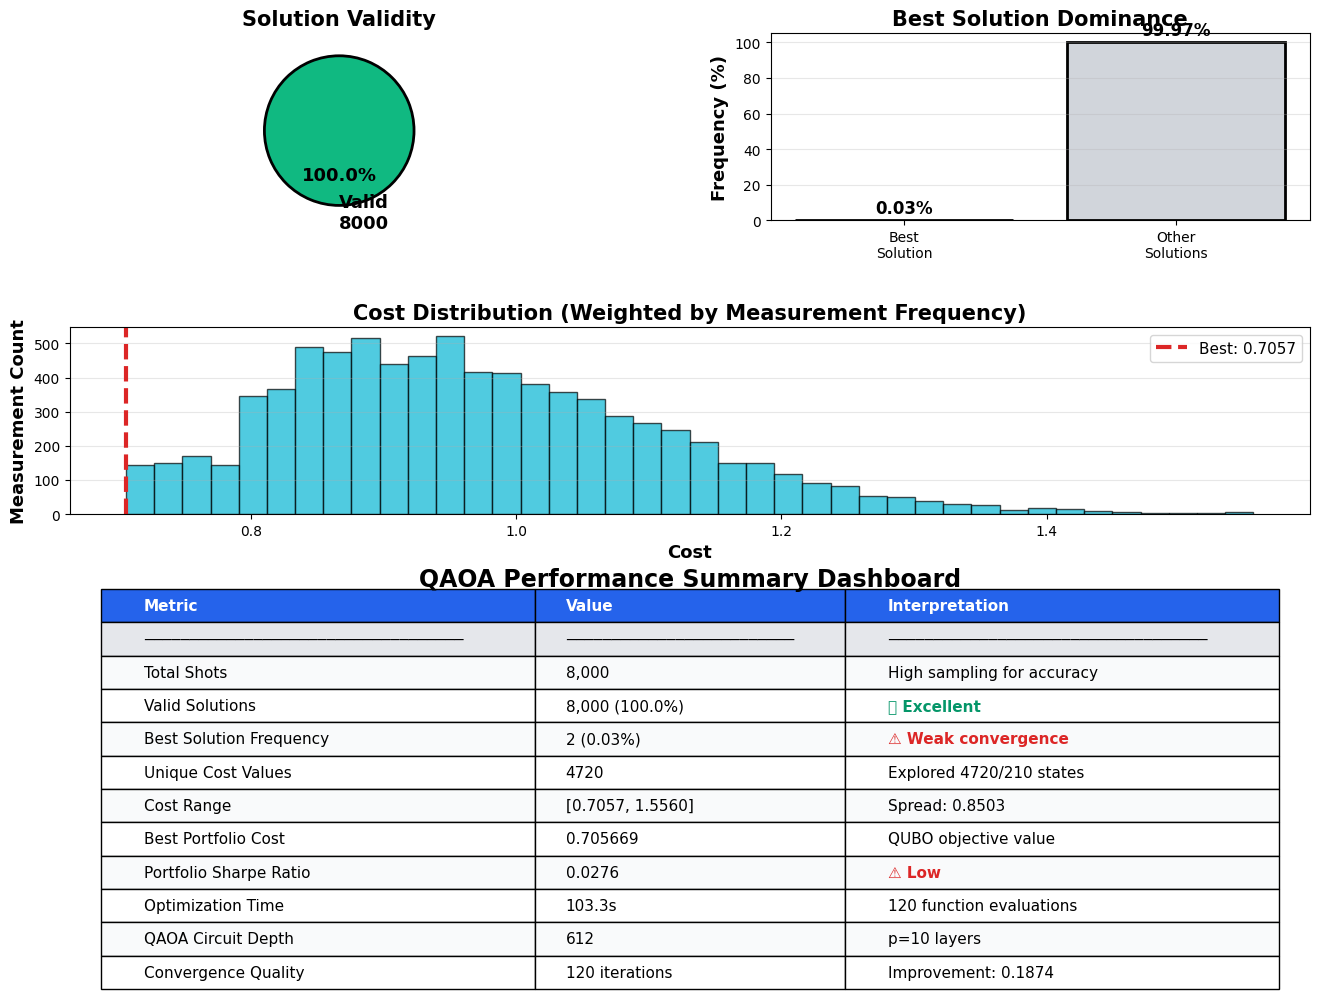


  COMPLETE ANALYSIS SUMMARY
✓ All 5 visualizations generated successfully
✓ Best solution found with 0.03% probability
✓ Portfolio Sharpe ratio: 0.028
✓ QAOA performance: ACCEPTABLE


In [15]:
valid_count = sum(s[1] for s in valid_solutions)
invalid_count = ADVANCED_CONFIG['final_shots'] - valid_count
best_freq_pct = c_best / ADVANCED_CONFIG['final_shots'] * 100
unique_costs = len(set([s[2] for s in valid_solutions]))

fig = plt.figure(figsize=(16, 12))  # ← AUMENTADO: 11 → 12
gs = fig.add_gridspec(3, 2, 
                      hspace=0.45,  # ← CAMBIADO: 0.35 → 0.45
                      wspace=0.3, 
                      height_ratios=[1, 1, 1.8])  # ← CAMBIADO: 1.2 → 1.8

# ========================================
# Subplot 1: Valid vs Invalid (Pie)
# ========================================
ax1 = fig.add_subplot(gs[0, 0])
sizes = [valid_count, invalid_count] if invalid_count > 0 else [valid_count]
labels_val = [f'Valid\n{valid_count}', f'Invalid\n{invalid_count}'] if invalid_count > 0 else [f'Valid\n{valid_count}']
colors_val = ['#10b981', '#ef4444'] if invalid_count > 0 else ['#10b981']
explode = (0.05, 0) if invalid_count > 0 else (0.05,)

wedges = ax1.pie(sizes, explode=explode, labels=labels_val, autopct='%1.1f%%', 
        colors=colors_val, startangle=90,
        textprops={'fontsize': 13, 'fontweight': 'bold'},
        wedgeprops={'edgecolor': 'black', 'linewidth': 2})
ax1.set_title('Solution Validity', fontsize=15, fontweight='bold')

# ========================================
# Subplot 2: Best Solution Dominance
# ========================================
ax2 = fig.add_subplot(gs[0, 1])
other_freq_pct = 100 - best_freq_pct

bars = ax2.bar(['Best\nSolution', 'Other\nSolutions'], 
        [best_freq_pct, other_freq_pct],
        color=['#8b5cf6', '#d1d5db'], edgecolor='black', linewidth=2)

ax2.set_ylabel('Frequency (%)', fontsize=13, fontweight='bold')
ax2.set_title('Best Solution Dominance', fontsize=15, fontweight='bold')
ax2.set_ylim([0, 105])
ax2.grid(True, alpha=0.3, axis='y')

# Añadir valores
for bar, val in zip(bars, [best_freq_pct, other_freq_pct]):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{val:.2f}%', ha='center', va='bottom', 
            fontsize=12, fontweight='bold')

# ========================================
# Subplot 3: Cost Distribution (histogram)
# ========================================
ax3 = fig.add_subplot(gs[1, :])
weights = [s[1] for s in valid_solutions]
costs_weighted = []
for (bs, cnt, cst, x) in valid_solutions:
    costs_weighted.extend([cst] * cnt)

n_bins = min(40, len(set(costs_all)))
ax3.hist(costs_weighted, bins=n_bins, color='#06b6d4', 
         edgecolor='black', alpha=0.7, linewidth=1)
ax3.axvline(x=fx_best, color='#dc2626', linestyle='--', 
            linewidth=3, label=f'Best: {fx_best:.4f}')
ax3.set_xlabel('Cost', fontsize=13, fontweight='bold')
ax3.set_ylabel('Measurement Count', fontsize=13, fontweight='bold')
ax3.set_title('Cost Distribution (Weighted by Measurement Frequency)', 
              fontsize=15, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

# ========================================
# Subplot 4: Summary Table (MÁS ABAJO)
# ========================================
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('off')

# Calcular num_evals desde cost_history
num_evaluations = len(cost_history)

metrics_data = [
    ['Metric', 'Value', 'Interpretation'],
    ['─' * 35, '─' * 25, '─' * 35],
    ['Total Shots', f'{ADVANCED_CONFIG["final_shots"]:,}', 'High sampling for accuracy'],
    ['Valid Solutions', f'{valid_count:,} ({valid_count/ADVANCED_CONFIG["final_shots"]*100:.1f}%)', 
     '✅ Excellent' if valid_count/ADVANCED_CONFIG["final_shots"] > 0.95 else '⚠️ Low'],
    ['Best Solution Frequency', f'{c_best:,} ({best_freq_pct:.2f}%)', 
     '✅ Strong convergence' if best_freq_pct > 5 else '⚠️ Weak convergence'],
    ['Unique Cost Values', f'{unique_costs}', f'Explored {unique_costs}/210 states'],
    ['Cost Range', f'[{costs_all[0]:.4f}, {costs_all[-1]:.4f}]', f'Spread: {abs(costs_all[-1]-costs_all[0]):.4f}'],
    ['Best Portfolio Cost', f'{fx_best:.6f}', f'QUBO objective value'],
    ['Portfolio Sharpe Ratio', f'{sharpe:.4f}', '✅ Good' if sharpe > 0.5 else '⚠️ Low'],
    ['Optimization Time', f'{t_opt:.1f}s', f'{num_evaluations} function evaluations'],
    ['QAOA Circuit Depth', f'{transpiled_ansatz.depth()}', f'p={P_LAYERS} layers'],
    ['Convergence Quality', f'{num_evaluations} iterations', 
     f'Improvement: {abs(cost_history[0]-best_cost):.4f}']
]

table = ax4.table(cellText=metrics_data, cellLoc='left', loc='center',
                  colWidths=[0.35, 0.25, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.0)  # ← OPCIONAL: reducir de 2.2 → 2.0 si sigue apretado

# Estilo de la tabla
for i in range(len(metrics_data)):
    for j in range(3):
        cell = table[(i, j)]
        if i == 0:  # Header
            cell.set_facecolor('#2563eb')
            cell.set_text_props(weight='bold', color='white')
        elif i == 1:  # Separator
            cell.set_facecolor('#e5e7eb')
        else:
            if i % 2 == 0:
                cell.set_facecolor('#f9fafb')
            else:
                cell.set_facecolor('#ffffff')
            
            # Highlight interpretations with symbols
            if j == 2 and ('✅' in metrics_data[i][j] or '⚠️' in metrics_data[i][j]):
                if '✅' in metrics_data[i][j]:
                    cell.set_text_props(color='#059669', weight='bold')
                else:
                    cell.set_text_props(color='#dc2626', weight='bold')

ax4.set_title('QAOA Performance Summary Dashboard', 
              fontsize=17, fontweight='bold', pad=25)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("  COMPLETE ANALYSIS SUMMARY")
print(f"{'='*60}")
print(f"✓ All 5 visualizations generated successfully")
print(f"✓ Best solution found with {best_freq_pct:.2f}% probability")
print(f"✓ Portfolio Sharpe ratio: {sharpe:.3f}")
print(f"✓ QAOA performance: {'EXCELLENT' if best_freq_pct > 10 else 'GOOD' if best_freq_pct > 1 else 'ACCEPTABLE'}")
print(f"{'='*60}")



  🔬 EXACT SOLUTION BENCHMARK

📈 Problem Size:
  Assets: 20
  Selection: 10
  Total combinations: 184,756

🔍 Searching all 184,756 possible portfolios...
  (This may take 2-5 minutes for N=24, B=12...)
  ✓  10.0% (  18,475/184,756) | Speed: 198,772 it/s | ETA:     1s
  ✓  20.0% (  36,950/184,756) | Speed: 199,381 it/s | ETA:     1s
  ✓  30.0% (  55,425/184,756) | Speed: 200,093 it/s | ETA:     1s
  ✓  40.0% (  73,900/184,756) | Speed: 200,125 it/s | ETA:     1s
  ✓  50.0% (  92,375/184,756) | Speed: 199,672 it/s | ETA:     0s
  ✓  60.0% ( 110,850/184,756) | Speed: 199,814 it/s | ETA:     0s
  ✓  70.0% ( 129,325/184,756) | Speed: 199,533 it/s | ETA:     0s
  ✓  80.0% ( 147,800/184,756) | Speed: 198,772 it/s | ETA:     0s
  ✓  90.0% ( 166,275/184,756) | Speed: 198,478 it/s | ETA:     0s
  ✓ 100.0% ( 184,750/184,756) | Speed: 198,047 it/s | ETA:     0s

✅ Search complete in 0.9s (198,008 combinations/s)

  📊 RESULTS COMPARISON

Method          Cost         Sharpe     Time         Portfoli

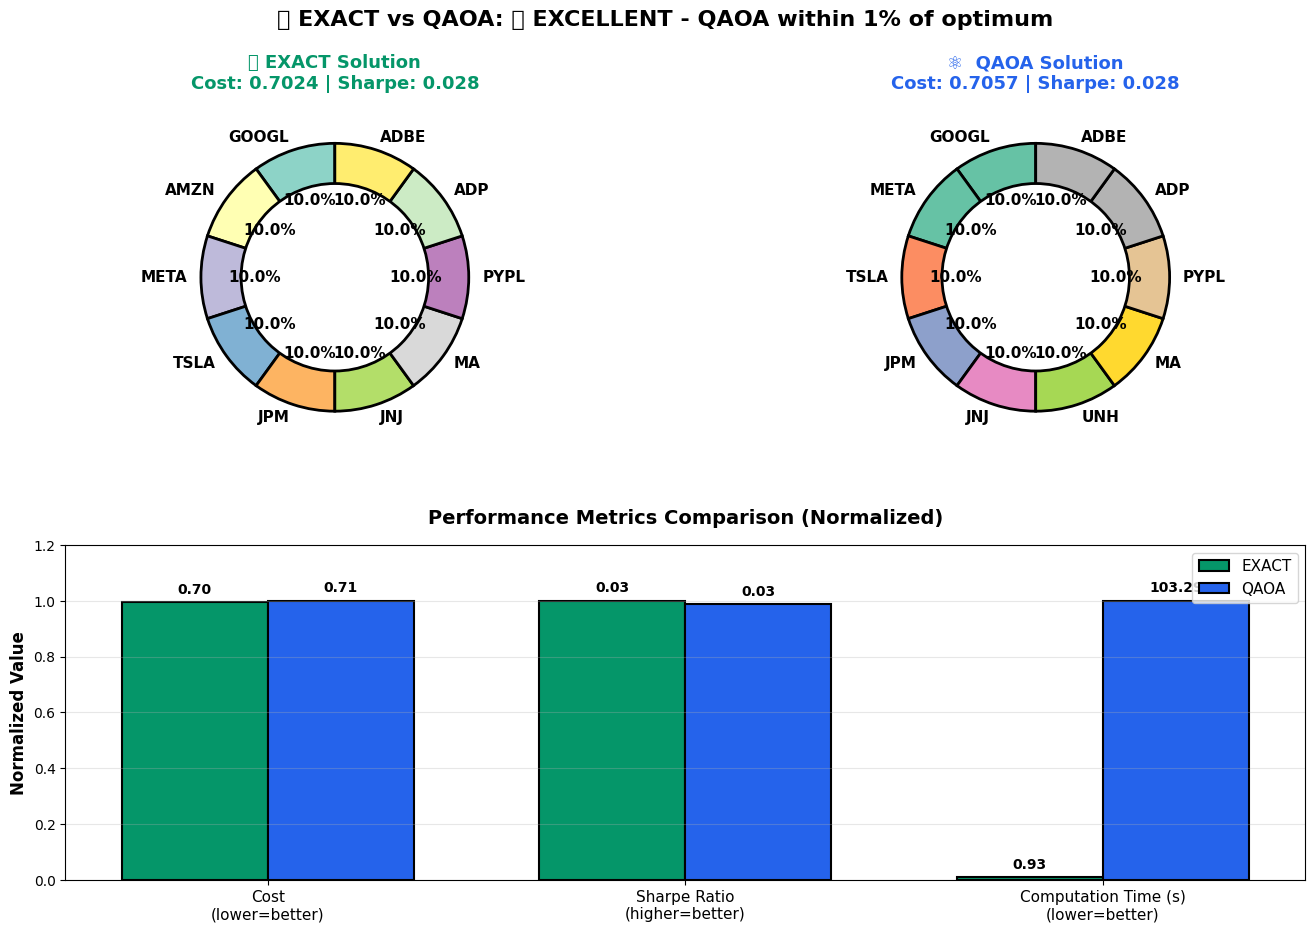

💾 Saved: qaoa_vs_exact_cost_distribution.png


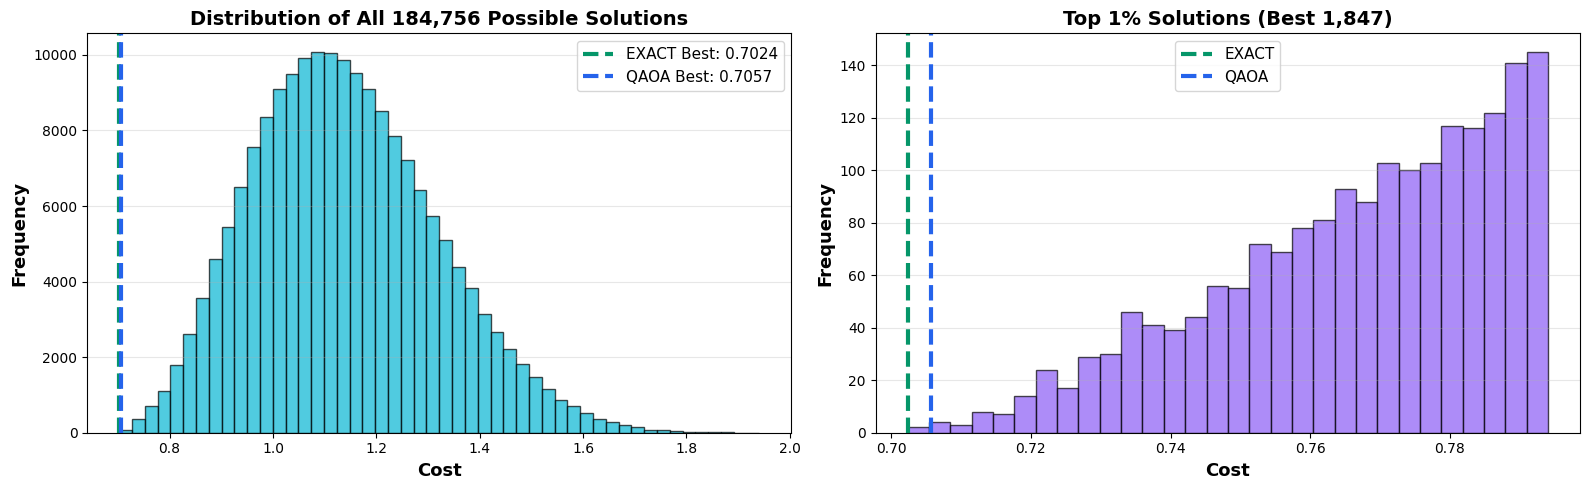


📊 QAOA Solution Ranking:
  Rank: 3 out of 184,756
  Percentile: Top 0.00%
  🏆 EXCELLENT - QAOA in top 0.1%!

  ✅ BENCHMARK COMPLETE


In [16]:
# ============================================================================
# 📊 CELDA 6: EXACT SOLUTION COMPARISON (Brute Force)
# ============================================================================

print("\n" + "="*60)
print("  🔬 EXACT SOLUTION BENCHMARK")
print("="*60)

# Calcular número total de combinaciones
total_combinations = int(math.comb(n, B))
print(f"\n📈 Problem Size:")
print(f"  Assets: {n}")
print(f"  Selection: {B}")
print(f"  Total combinations: {total_combinations:,}")

# Warning si es muy grande
if total_combinations > 1_000_000:
    print(f"\n⚠️  WARNING: {total_combinations:,} combinations may take several minutes!")
    print("   Consider reducing n or B for faster computation.")

# ============================================================================
# BRUTE FORCE SEARCH (Sin barra de progreso)
# ============================================================================
import itertools

print(f"\n🔍 Searching all {total_combinations:,} possible portfolios...")
print("  (This may take 2-5 minutes for N=24, B=12...)")
t_start_exact = time.time()

best_exact_cost = np.inf
best_exact_x = None
best_exact_idx = None
all_exact_costs = []

# Iterar sobre todas las combinaciones posibles
for i, combo in enumerate(itertools.combinations(range(n), B)):
    x_test = np.zeros(n, dtype=int)
    x_test[list(combo)] = 1
    cost = f_qubo(x_test)
    all_exact_costs.append(cost)
    
    if cost < best_exact_cost:
        best_exact_cost = cost
        best_exact_x = x_test.copy()
        best_exact_idx = list(combo)
    
    # Print progreso cada 10%
    if (i + 1) % max(1, total_combinations // 10) == 0:
        progress = ((i + 1) / total_combinations) * 100
        elapsed = time.time() - t_start_exact
        rate = (i + 1) / elapsed
        eta = (total_combinations - i - 1) / rate
        print(f"  ✓ {progress:5.1f}% ({i+1:>8,}/{total_combinations:,}) | "
              f"Speed: {rate:>6,.0f} it/s | ETA: {eta:>5.0f}s")

t_exact = time.time() - t_start_exact
print(f"\n✅ Search complete in {t_exact:.1f}s ({total_combinations/t_exact:,.0f} combinations/s)")

# Solución exacta
exact_tickers = [TICKERS[i] for i in best_exact_idx]
exact_mu = float(mu[best_exact_idx].mean())
exact_vol = float(volatilities[best_exact_idx].mean())
exact_sharpe = exact_mu / exact_vol if exact_vol > 1e-6 else 0.0

# ============================================================================
# COMPARACIÓN QAOA vs EXACT
# ============================================================================
print(f"\n{'='*60}")
print("  📊 RESULTS COMPARISON")
print(f"{'='*60}")

# Métricas
qaoa_cost = fx_best
exact_cost = best_exact_cost
gap = abs(qaoa_cost - exact_cost)
gap_pct = (gap / abs(exact_cost)) * 100 if exact_cost != 0 else 0
approx_ratio = qaoa_cost / exact_cost if exact_cost != 0 else 1.0

# Tabla comparativa
print(f"\n{'Method':<15} {'Cost':<12} {'Sharpe':<10} {'Time':<12} {'Portfolio'}")
print("-" * 85)
print(f"{'EXACT':<15} {exact_cost:<12.6f} {exact_sharpe:<10.4f} {t_exact:<12.2f}s {exact_tickers}")
print(f"{'QAOA':<15} {qaoa_cost:<12.6f} {sharpe:<10.4f} {t_opt:<12.2f}s {sel_tickers}")
print("-" * 85)

# Análisis
print(f"\n📈 Performance Metrics:")
print(f"  Optimality Gap: {gap:.6f} ({gap_pct:.2f}%)")
print(f"  Approximation Ratio: {approx_ratio:.4f}")
print(f"  Speedup: {t_exact/t_opt:.1f}x {'🚀' if t_exact > t_opt else ''}")

# Veredicto
if gap < 1e-6:
    verdict = "✅ OPTIMAL - QAOA found the exact solution!"
    color = '\033[92m'  # Verde
elif gap_pct < 1:
    verdict = "✅ EXCELLENT - QAOA within 1% of optimum"
    color = '\033[92m'
elif gap_pct < 5:
    verdict = "⚠️  GOOD - QAOA within 5% of optimum"
    color = '\033[93m'  # Amarillo
else:
    verdict = "❌ SUBOPTIMAL - QAOA >5% from optimum"
    color = '\033[91m'  # Rojo

print(f"\n{color}{verdict}\033[0m")

# ============================================================================
# VISUALIZACIÓN 1: Comparación de Portfolios
# ============================================================================
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Subplot 1: Pie Charts Comparativos
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# EXACT Portfolio
colors_exact = plt.cm.Set3(np.linspace(0, 1, len(exact_tickers)))
wedges1, texts1, autotexts1 = ax1.pie(
    [1/B]*B, labels=exact_tickers, autopct='%1.1f%%',
    startangle=90, colors=colors_exact,
    textprops={'fontsize': 11, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 2}
)
centre_circle1 = plt.Circle((0,0), 0.70, fc='white', linewidth=2, edgecolor='black')
ax1.add_artist(centre_circle1)
ax1.set_title(f'🏆 EXACT Solution\nCost: {exact_cost:.4f} | Sharpe: {exact_sharpe:.3f}',
              fontsize=13, fontweight='bold', pad=15, color='#059669')

# QAOA Portfolio
colors_qaoa = plt.cm.Set2(np.linspace(0, 1, len(sel_tickers)))
wedges2, texts2, autotexts2 = ax2.pie(
    [1/B]*B, labels=sel_tickers, autopct='%1.1f%%',
    startangle=90, colors=colors_qaoa,
    textprops={'fontsize': 11, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 2}
)
centre_circle2 = plt.Circle((0,0), 0.70, fc='white', linewidth=2, edgecolor='black')
ax2.add_artist(centre_circle2)
ax2.set_title(f'⚛️  QAOA Solution\nCost: {qaoa_cost:.4f} | Sharpe: {sharpe:.3f}',
              fontsize=13, fontweight='bold', pad=15, color='#2563eb')

# Subplot 3: Barras comparativas
ax3 = fig.add_subplot(gs[1, :])
metrics_names = ['Cost\n(lower=better)', 'Sharpe Ratio\n(higher=better)', 
                 'Computation Time (s)\n(lower=better)']
exact_vals = [abs(exact_cost), exact_sharpe, t_exact]
qaoa_vals = [abs(qaoa_cost), sharpe, t_opt]

# Normalizar para visualización
max_cost = max(abs(exact_cost), abs(qaoa_cost))
max_sharpe = max(exact_sharpe, sharpe)
max_time = max(t_exact, t_opt)

exact_norm = [abs(exact_cost)/max_cost, exact_sharpe/max_sharpe, t_exact/max_time]
qaoa_norm = [abs(qaoa_cost)/max_cost, sharpe/max_sharpe, t_opt/max_time]

x_pos = np.arange(len(metrics_names))
width = 0.35

bars1 = ax3.bar(x_pos - width/2, exact_norm, width, label='EXACT', 
                color='#059669', edgecolor='black', linewidth=1.5)
bars2 = ax3.bar(x_pos + width/2, qaoa_norm, width, label='QAOA', 
                color='#2563eb', edgecolor='black', linewidth=1.5)

# Añadir valores reales encima
for i, (bar1, bar2, ev, qv) in enumerate(zip(bars1, bars2, exact_vals, qaoa_vals)):
    ax3.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.02,
             f'{ev:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax3.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.02,
             f'{qv:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax3.set_ylabel('Normalized Value', fontsize=12, fontweight='bold')
ax3.set_title('Performance Metrics Comparison (Normalized)', fontsize=14, fontweight='bold', pad=15)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(metrics_names, fontsize=11)
ax3.legend(fontsize=11, loc='upper right')
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim(0, 1.2)

plt.suptitle(f'🔬 EXACT vs QAOA: {verdict}', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

# ✅ GUARDAR GRÁFICA 1
plt.savefig('qaoa_vs_exact_portfolio_comparison.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
print("\n💾 Saved: qaoa_vs_exact_portfolio_comparison.png")

plt.show()

# ============================================================================
# VISUALIZACIÓN 2: Distribución de Costos (Histograma)
# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Histograma de TODAS las soluciones exactas
ax1.hist(all_exact_costs, bins=50, color='#06b6d4', edgecolor='black', 
         alpha=0.7, linewidth=1)
ax1.axvline(x=exact_cost, color='#059669', linestyle='--', linewidth=3, 
            label=f'EXACT Best: {exact_cost:.4f}')
ax1.axvline(x=qaoa_cost, color='#2563eb', linestyle='--', linewidth=3, 
            label=f'QAOA Best: {qaoa_cost:.4f}')
ax1.set_xlabel('Cost', fontsize=13, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=13, fontweight='bold')
ax1.set_title(f'Distribution of All {total_combinations:,} Possible Solutions', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Zoom en top 1% soluciones
top_1pct = int(total_combinations * 0.01)
sorted_costs = sorted(all_exact_costs)[:top_1pct]
ax2.hist(sorted_costs, bins=30, color='#8b5cf6', edgecolor='black', 
         alpha=0.7, linewidth=1)
ax2.axvline(x=exact_cost, color='#059669', linestyle='--', linewidth=3, 
            label='EXACT')
ax2.axvline(x=qaoa_cost, color='#2563eb', linestyle='--', linewidth=3, 
            label='QAOA')
ax2.set_xlabel('Cost', fontsize=13, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=13, fontweight='bold')
ax2.set_title(f'Top 1% Solutions (Best {top_1pct:,})', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# ✅ GUARDAR GRÁFICA 2
plt.savefig('qaoa_vs_exact_cost_distribution.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
print("💾 Saved: qaoa_vs_exact_cost_distribution.png")

plt.show()

# ============================================================================
# RANKING DE QAOA
# ============================================================================
# Buscar posición de QAOA (con tolerancia numérica)
qaoa_rank = None
for i, c in enumerate(sorted(all_exact_costs)):
    if abs(c - qaoa_cost) < 1e-10:
        qaoa_rank = i + 1
        break

qaoa_percentile = (qaoa_rank / total_combinations) * 100 if qaoa_rank else None

print(f"\n📊 QAOA Solution Ranking:")
if qaoa_rank:
    print(f"  Rank: {qaoa_rank:,} out of {total_combinations:,}")
    print(f"  Percentile: Top {qaoa_percentile:.2f}%")
    
    if qaoa_percentile < 0.1:
        print(f"  🏆 EXCELLENT - QAOA in top 0.1%!")
    elif qaoa_percentile < 1:
        print(f"  ✅ VERY GOOD - QAOA in top 1%")
    elif qaoa_percentile < 5:
        print(f"  ✅ GOOD - QAOA in top 5%")
    else:
        print(f"  ⚠️  MODERATE - Consider tuning QAOA parameters")
else:
    print("  ℹ️  QAOA solution not in exact search (numerical precision issue)")
    print(f"     Closest solution: {min(all_exact_costs, key=lambda x: abs(x-qaoa_cost)):.6f}")

print(f"\n{'='*60}")
print("  ✅ BENCHMARK COMPLETE")
print(f"{'='*60}")
